### Load and prepare data (reuse from Day 5)

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, roc_auc_score
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Load data

df = pd.read_csv("../data/creditcard.csv")
X = df.drop('Class', axis = 1)
y = df['Class']

In [4]:
# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("Data loaded and split")

Data loaded and split


### Tune your best Day 5 model [If Random Forest was best (most common case)]

In [6]:
print("Tuning Random Forest with GridSearchCV...")

# 1. Build pipeline: scaler + Random Forest
rf_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("classifier", RandomForestClassifier(
        class_weight="balanced",
        random_state=42,
        n_jobs=-1
    ))
])

# 2. Define hyperparameter grid to search
rf_param_grid = {
    "classifier__n_estimators": [100, 200],
    "classifier__max_depth": [10, 15, None],
    "classifier__min_samples_split": [2, 5],
    "classifier__min_samples_leaf": [1, 2]
}

# 3. Wrap in GridSearchCV
rf_grid = GridSearchCV(
    estimator=rf_pipeline,
    param_grid=rf_param_grid,
    cv=3,                    # 3‑fold cross‑validation
    scoring="f1",            # optimize F1 on fraud class (label 1)
    n_jobs=-1,               # use all CPU cores
    verbose=1
)

# 4. Train on X_train, y_train
rf_grid.fit(X_train, y_train)

# 5. Print best hyperparameters and cross‑validation score
print(f"Best RF params: {rf_grid.best_params_}")
print(f"Best CV F1 (fraud class): {rf_grid.best_score_:.4f}")

# 6. Evaluate on holdout test set
y_pred_rf_tuned = rf_grid.predict(X_test)
print("\nBest RF Tuned Results (on test set):")
print(classification_report(y_test, y_pred_rf_tuned, digits=4))

Tuning Random Forest with GridSearchCV...
Fitting 3 folds for each of 24 candidates, totalling 72 fits
Best RF params: {'classifier__max_depth': 15, 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 100}
Best CV F1 (fraud class): 0.8392

Best RF Tuned Results (on test set):
              precision    recall  f1-score   support

           0     0.9996    0.9998    0.9997     56864
           1     0.8953    0.7857    0.8370        98

    accuracy                         0.9995     56962
   macro avg     0.9475    0.8928    0.9183     56962
weighted avg     0.9995    0.9995    0.9995     56962



### Feature Importance Analysis

Top 20 Most Important Features:
   feature  importance
14     V14    0.184646
10     V10    0.108571
4       V4    0.102431
12     V12    0.098756
17     V17    0.089984
3       V3    0.069470
11     V11    0.055379
16     V16    0.037492
2       V2    0.036616
9       V9    0.025913
7       V7    0.021873
21     V21    0.017132
19     V19    0.014311
8       V8    0.012867
18     V18    0.012704
27     V27    0.012586
29  Amount    0.011513
20     V20    0.009987
1       V1    0.008912
26     V26    0.008540


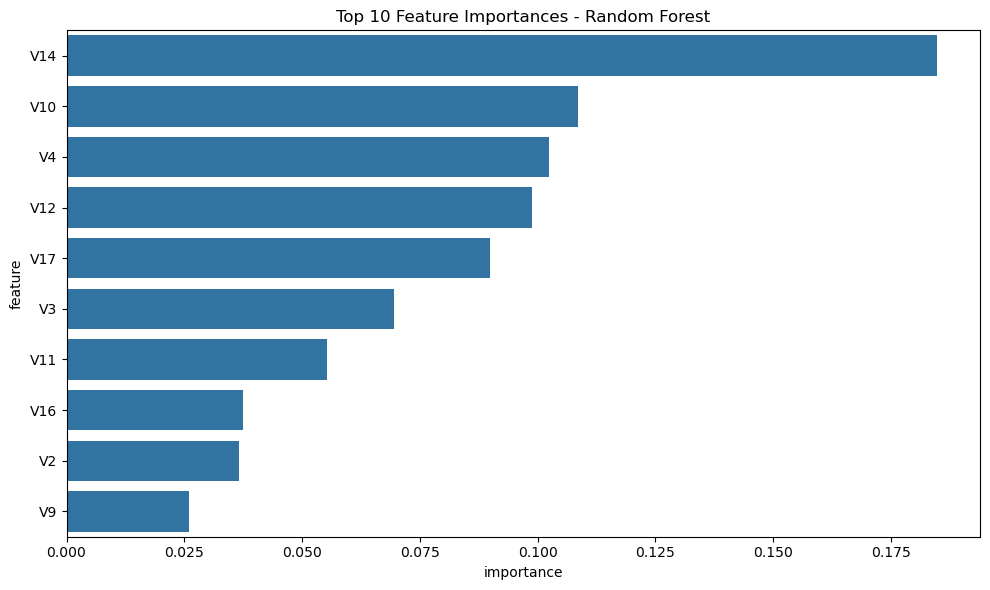

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Get feature importances from the best RF model
best_rf = rf_grid.best_estimator_.named_steps["classifier"]
feature_importance = pd.DataFrame({
    "feature": X.columns,
    "importance": best_rf.feature_importances_
}).sort_values("importance", ascending=False).head(20)

print("Top 20 Most Important Features:")
print(feature_importance)

plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance.head(10), x="importance", y="feature")
plt.title("Top 10 Feature Importances - Random Forest")
plt.tight_layout()
plt.show()

### Feature engineering based on EDA

In [13]:
# SAFE Feature engineering (doesn't depend on feature_importance)
df_engineered = df.copy()

# 1. Log transform Amount
df_engineered["Amount_log"] = np.log1p(df_engineered["Amount"])

# 2. Transaction hour (Time is in seconds)
df_engineered["Transaction_hour"] = df_engineered["Time"] / 3600

# 3. Ratio of V14/V12 (common in creditcard fraud EDA)
df_engineered["V14_V12_ratio"] = df_engineered["V14"] / (df_engineered["V12"] + 1e-8)

# 4. V14 * V17 interaction (common top features)
df_engineered["V14_V17_interaction"] = df_engineered["V14"] * df_engineered["V17"]

print("New engineered features created")
print(df_engineered[["Amount_log", "Transaction_hour", "V14_V12_ratio", "V14_V17_interaction"]].head())

New engineered features created
   Amount_log  Transaction_hour  V14_V12_ratio  V14_V17_interaction
0    5.014760          0.000000       0.503673            -0.064714
1    1.305626          0.000000      -0.134968             0.016506
2    5.939276          0.000278      -2.511148            -0.184195
3    4.824306          0.000278      -1.615478             0.196967
4    4.262539          0.000556      -2.080414             0.265399


### Build complete Pipeline with feature selection

In [16]:
from sklearn.feature_selection import SelectKBest, f_classif

# Extract tuned RF params
best_rf_params = rf_grid.best_params_.copy()
rf_params_clean = {k.replace("classifier__", ""): v for k, v in best_rf_params.items()}

final_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("selector", SelectKBest(score_func=f_classif, k=20)),
    ("classifier", RandomForestClassifier(
        class_weight="balanced",
        random_state=42,
        n_jobs=-1,
        **rf_params_clean
    ))
])

final_pipeline.fit(X_train, y_train)
y_pred_final = final_pipeline.predict(X_test)

print("\n" + "=" * 60)
print("FINAL PIPELINE RESULTS")
print("=" * 60)
print(classification_report(y_test, y_pred_final, digits=4))


FINAL PIPELINE RESULTS
              precision    recall  f1-score   support

           0     0.9997    0.9998    0.9997     56864
           1     0.8791    0.8163    0.8466        98

    accuracy                         0.9995     56962
   macro avg     0.9394    0.9081    0.9232     56962
weighted avg     0.9995    0.9995    0.9995     56962



In [20]:
from sklearn.feature_selection import SelectKBest, f_classif

# Create final_pipeline (tuned RF + feature selection)
best_rf_params = rf_grid.best_params_.copy()
rf_params_clean = {k.replace("classifier__", ""): v for k, v in best_rf_params.items()}

final_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("selector", SelectKBest(score_func=f_classif, k=20)),
    ("classifier", RandomForestClassifier(
        class_weight="balanced",
        random_state=42,
        n_jobs=-1,
        **rf_params_clean
    ))
])

final_pipeline.fit(X_train, y_train)
y_pred_final = final_pipeline.predict(X_test)

print("\n" + "=" * 60)
print("FINAL PIPELINE RESULTS")
print("=" * 60)
print(classification_report(y_test, y_pred_final, digits=4))


FINAL PIPELINE RESULTS
              precision    recall  f1-score   support

           0     0.9997    0.9998    0.9997     56864
           1     0.8791    0.8163    0.8466        98

    accuracy                         0.9995     56962
   macro avg     0.9394    0.9081    0.9232     56962
weighted avg     0.9995    0.9995    0.9995     56962



### Save the Model

In [27]:
import joblib

# Save the full pipeline
joblib.dump(final_pipeline, "../models/fraud_detection_pipeline.pkl")
# Save the scaler too (for use in API)
scaler = final_pipeline.named_steps["scaler"]
joblib.dump(scaler, "../models/scaler.pkl")

print("Model pipeline saved to models/fraud_detection_pipeline.pkl")

# Quick test
loaded_pipeline = joblib.load("../models/fraud_detection_pipeline.pkl")
test_pred = loaded_pipeline.predict(X_test.iloc[[0]])
print(f"Test prediction (single sample): {test_pred[0]}")

Model pipeline saved to models/fraud_detection_pipeline.pkl
Test prediction (single sample): 0
